## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as wb
import matplotlib.pyplot as plt
import itertools
from tqdm.notebook import tqdm

## Retrieve Data

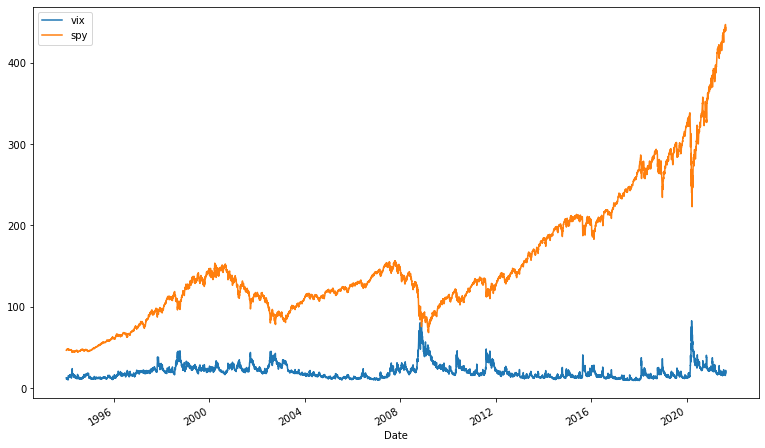

In [2]:
# specify dates and tickers
start_date = '1994-01-03'
end_date = None
tickers = ['^VIX','SPY']

# retrieve data from yahoo finance
data = wb.DataReader(tickers, 'yahoo', start_date, end_date)['Close']

# fill forward missing values
data.fillna(method='pad', inplace=True)
data.columns = ['vix','spy']

# compute spy daily return
data['spy_return'] = data['spy'].pct_change()

# visualize time-series
data[['vix','spy']].plot(figsize=(13,8)); plt.show()

## Functionalize Backtest Engine

In [3]:
# functionalize backtest engine
def volatility_backtest(start, end, short_ma, long_ma, tc=1, plot=False):
    # parse data type
    if isinstance(start, int): start = str(start)
    if isinstance(end, int): end = str(end) 
    
    # slice training and testing dataset
    sliced_data = data.loc[start:end].copy()        

    # compute vix moving averages
    sliced_data['vix_short_ma'] = sliced_data['vix'].rolling(short_ma).mean()
    sliced_data['vix_long_ma'] = sliced_data['vix'].rolling(long_ma).mean()

    # generate trading signals
    sliced_data['signal'] = (sliced_data.dropna()['vix_short_ma'] < sliced_data.dropna()['vix_long_ma']).astype(int)

    # generate strategy daily return with 1-day execution lag
    sliced_data['strat_return'] = sliced_data['spy_return'] * sliced_data['signal'].shift(2)

    # include transaction cost
    cost = tc / 10000
    turnover = sliced_data['signal'].shift().diff().fillna(0).abs()
    sliced_data['strat_return'] = sliced_data['strat_return'] - (turnover * cost)

    # compute sharpe ratio
    sharpe = get_sharpe_ratio(sliced_data['strat_return'])

    # compute maximum drawdown
    max_drawdown = get_max_drawdown(sliced_data['strat_return'])
    
    pnl = sliced_data['strat_return'].dropna().cumsum()
    high_watermark = pnl.cummax()
    daily_drawdown = pnl - high_watermark
    max_drawdown = daily_drawdown.abs().max()
    
    if plot:
        (sliced_data['strat_return'] + 1).cumprod(skipna=True).plot(figsize=(13,8))
        plt.show()
        
    return sharpe, max_drawdown

In [4]:
# define helper functions
def get_sharpe_ratio(daily_return):
    return daily_return.mean() / daily_return.std() * np.sqrt(250)

def get_max_drawdown(daily_return):
    rolling_max = (daily_return + 1).cumprod().expanding().max()
    daily_drawdown = (daily_return + 1).cumprod() / rolling_max.values - 1.0
    max_drawdown = daily_drawdown.abs().max() * 100
    return max_drawdown

def get_annualized_return(daily_return):
    annual_return = np.prod(daily_return.dropna().resample('A').sum() + 1) \
                    ** (1/len(daily_return.dropna().resample('A').sum())) - 1
    return annual_return * 100

### Try Out the Function!

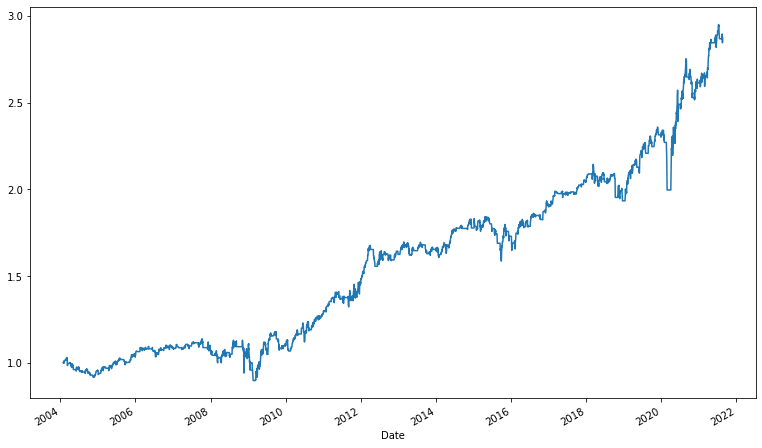

(0.5981396345535426, 0.2116435773584723)

In [5]:
volatility_backtest(start=2004, end=None, short_ma=15, long_ma=17, plot=True)

## Grid Search Parameters

In [6]:
# copy original dataframe
test_data = data.copy()

# set training interval (in years)
train_interval = 10

# take the n-best params to avoid overfitting
regularization = 2

# loop over to train data
years = list(sorted(set(data.index.year)))
for i in range(len(years)-train_interval):
    
    # set reference year
    start_train = str(years[i])
    end_train = str(years[i+train_interval-1])
    alloc_year = str(years[i+train_interval])
    print(f"Training dataset from {start_train} to {end_train}..")
    
    # set parameters range
    short = range(1, 31, 1)
    long = range(1, 71, 1)
    
    # consolidate all possible combinations
    param_combi = list(itertools.product(short, long))
    param_combi = [combi for combi in param_combi if (combi[0] < combi[1])]
    summary = pd.DataFrame(index=range(len(param_combi)), columns=['short_ma','long_ma','sharpe','max_drawdown'])
    
    # grid search optimum parameters
    values = range(len(param_combi))
    with tqdm(total=len(values), position=0, leave=True) as pbar:
        for i in values:
            pbar.set_description(f"Evaluating combination {param_combi[i]}")
            pbar.update()
            short_ma, long_ma = param_combi[i]
            sharpe, max_dd = volatility_backtest(start_train, end_train, short_ma, long_ma)
            summary.iloc[i,:] = [short_ma, long_ma, sharpe, max_dd]
    summary['ratio'] = summary['sharpe'] / summary['max_drawdown']
    
    # capture optimum parameters
    short_ma = summary.sort_values(by='ratio', ascending=False).iloc[regularization-1]['short_ma']
    long_ma = summary.sort_values(by='ratio', ascending=False).iloc[regularization-1]['long_ma']
    print(f"Using {short_ma} and {long_ma} crossover for {alloc_year}..\n")
    
    # use parameters to compute trading signals
    alloc_data = data.loc[start_train:alloc_year].copy()        

    # compute vix moving averages
    alloc_data['vix_short_ma'] = alloc_data['vix'].rolling(short_ma).mean()
    alloc_data['vix_long_ma'] = alloc_data['vix'].rolling(long_ma).mean()

    # generate long-only trading signal
    alloc_data['signal'] = (alloc_data['vix_short_ma'] < alloc_data['vix_long_ma']).astype(int)
    
    # assign trading signal to test dataframe
    test_data.loc[alloc_year,'signal'] = alloc_data.loc[alloc_year,'signal'].values

Training dataset from 1994 to 2003..


  0%|          | 0/1635 [00:00<?, ?it/s]

Using 15 and 21 crossover for 2004..

Training dataset from 1995 to 2004..


  0%|          | 0/1635 [00:00<?, ?it/s]

Using 14 and 20 crossover for 2005..

Training dataset from 1996 to 2005..


  0%|          | 0/1635 [00:00<?, ?it/s]

Using 14 and 20 crossover for 2006..

Training dataset from 1997 to 2006..


  0%|          | 0/1635 [00:00<?, ?it/s]

Using 14 and 20 crossover for 2007..

Training dataset from 1998 to 2007..


  0%|          | 0/1635 [00:00<?, ?it/s]

Using 14 and 20 crossover for 2008..

Training dataset from 1999 to 2008..


  0%|          | 0/1635 [00:00<?, ?it/s]

Using 15 and 17 crossover for 2009..

Training dataset from 2000 to 2009..


  0%|          | 0/1635 [00:00<?, ?it/s]

Using 15 and 17 crossover for 2010..

Training dataset from 2001 to 2010..


  0%|          | 0/1635 [00:00<?, ?it/s]

Using 15 and 17 crossover for 2011..

Training dataset from 2002 to 2011..


  0%|          | 0/1635 [00:00<?, ?it/s]

Using 15 and 17 crossover for 2012..

Training dataset from 2003 to 2012..


  0%|          | 0/1635 [00:00<?, ?it/s]

Using 15 and 17 crossover for 2013..

Training dataset from 2004 to 2013..


  0%|          | 0/1635 [00:00<?, ?it/s]

Using 15 and 17 crossover for 2014..

Training dataset from 2005 to 2014..


  0%|          | 0/1635 [00:00<?, ?it/s]

Using 15 and 16 crossover for 2015..

Training dataset from 2006 to 2015..


  0%|          | 0/1635 [00:00<?, ?it/s]

Using 24 and 27 crossover for 2016..

Training dataset from 2007 to 2016..


  0%|          | 0/1635 [00:00<?, ?it/s]

Using 29 and 30 crossover for 2017..

Training dataset from 2008 to 2017..


  0%|          | 0/1635 [00:00<?, ?it/s]

Using 18 and 26 crossover for 2018..

Training dataset from 2009 to 2018..


  0%|          | 0/1635 [00:00<?, ?it/s]

Using 2 and 60 crossover for 2019..

Training dataset from 2010 to 2019..


  0%|          | 0/1635 [00:00<?, ?it/s]

Using 2 and 58 crossover for 2020..

Training dataset from 2011 to 2020..


  0%|          | 0/1635 [00:00<?, ?it/s]

Using 2 and 61 crossover for 2021..



## Visualize Performance

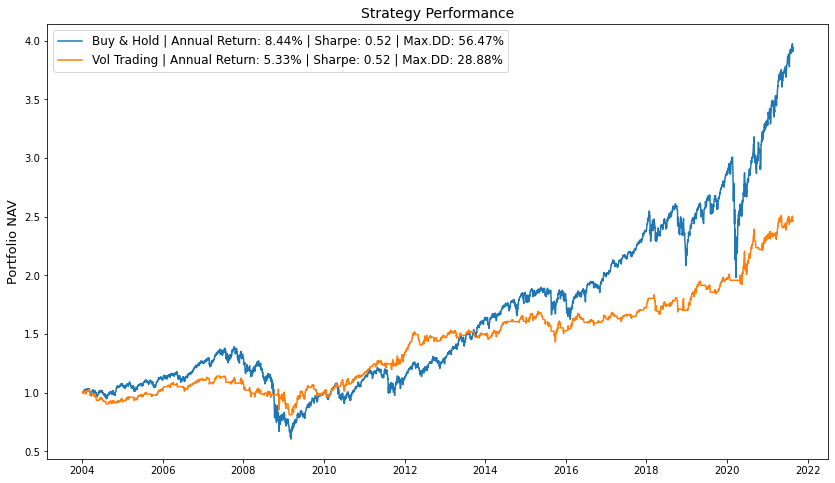

In [7]:
# generate strategy daily return with 1-day execution lag
test_data['strat_return'] = test_data['spy_return'] * test_data['signal'].shift(2)

# include transaction cost
cost = 1 / 10000
turnover = test_data['signal'].shift().diff().fillna(0).abs()
test_data['strat_return'] = test_data['strat_return'] - (turnover * cost)
    
# visualize performance
plt.figure(figsize=(14,8))
plt.title('Strategy Performance', fontsize=14)
plt.ylabel('Portfolio NAV', fontsize=13)

plt.plot((test_data.dropna()['spy_return'] + 1).cumprod(),
         label=f"Buy & Hold | Annual Return: {get_annualized_return(test_data['spy_return']):.2f}% | Sharpe: {get_sharpe_ratio(test_data['spy_return']):.2f} | Max.DD: {get_max_drawdown(test_data['spy_return']):.2f}%")

plt.plot((test_data.dropna()['strat_return'] + 1).cumprod(),
         label=f"Vol Trading | Annual Return: {get_annualized_return(test_data['strat_return']):.2f}% | Sharpe: {get_sharpe_ratio(test_data['strat_return']):.2f} | Max.DD: {get_max_drawdown(test_data['strat_return']):.2f}%")

plt.legend(fontsize=12)
plt.show()

## The End